# Loading & Preprocessing Dataset

Loading the dataset from torchvision and preparing the DataLoaders after transform operations

In [1]:
import torch
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
from torchvision import models, datasets, transforms

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist_train = datasets.MNIST(root='mnist', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='mnist', train=False, download=True, transform=transform)
labels = mnist_train.classes

batchsize=64
train_dl = DataLoader(mnist_train, batch_size=batchsize, shuffle=True)
test_dl = DataLoader(mnist_test, batch_size=batchsize, shuffle=False)

# Defining custom CNN

Single layer consists of => Conv2D - BatchNorm - LeakyReLU - MaxPool2D - Dropout
Last layer consists of => Flatten - Fully Connected - LeakyReLU - Dropout - Fully Connected

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

class CNN_MNIST(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1), # kernel = 5, padding = 2
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(p=0.25),

            nn.Conv2d(16, 32, kernel_size=3, padding=1), # kernel = 5, padding = 2
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(p=0.25),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(p=0.25),

            nn.Flatten(),
            nn.Linear(3*3*64, 512),
            nn.LeakyReLU(),
            nn.Dropout(p=0.25),
            nn.Linear(512, 10)
        )
    def forward(self, b):
        return self.network(b)

model = CNN_MNIST().to(device)
model

cuda


CNN_MNIST(
  (network): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.25, inplace=False)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout2d(p=0.25, inplace=False)
    (10): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.01)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dro

# GPU status

In [3]:
import torch
torch.cuda.empty_cache()
!nvidia-smi

Tue May 17 21:27:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.77       Driver Version: 512.77       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   43C    P0    20W /  N/A |    120MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Training the model

Epochs = 20
Loss function = Crossentropy
Optimizer = Adam
Learning Rate scheduler has been used

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

import numpy as np
from torch.optim import Adam, lr_scheduler
from torch import nn
import copy, timeit

optimizer = Adam(model.parameters(), lr=0.001)
xent = nn.CrossEntropyLoss()
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

if device!='cpu':
    model = model.to(device)

val_loss = []
val_acc = []
train_loss = []
train_acc = []
epochs = 20

best_acc = 0
best_model = copy.deepcopy(model.state_dict())

start = timeit.default_timer()
for epoch in range(1, epochs+1):
    print(f"Epoch : {epoch}\n")
    dataloader = None
    
    for phase in ['train', 'val']:
        loss = 0
        correct = 0
        total = 0
        batch_num = 0
        
        if phase == 'train' :
            model.train()
            dataloader = train_dl
        else:
            model.eval()
            dataloader = test_dl

        for (img, label) in dataloader:
            img, label = img.to(device), label.to(device)
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                output = model(img)
                _, pred = torch.max(output.data, 1)
                loss = xent(output, label)
                if phase=='train' :
                    loss.backward()
                    optimizer.step()
            
            loss += loss.item() * img.size(0)
            torch.cuda.empty_cache()
            correct += torch.sum(pred == label.data)
            total += label.size(0)
            batch_num += 1
            #if batch_num % 10 == 0:
            #    print(f"{phase} batch {batch_num} completed")
        
        if phase=='train' :
            train_loss.append(loss/len(train_dl))
            train_acc.append(correct/total)
            scheduler.step()
            print(f'{phase} Loss: {train_loss[-1]:.4f}\tAccuracy: {train_acc[-1]:.4f}')
        else :
            val_loss.append(loss/len(test_dl))
            val_acc.append(correct/total)
            print(f'{phase} Loss: {val_loss[-1]:.4f}\tAccuracy: {val_acc[-1]:.4f}')

            if val_acc[-1] > best_acc :
                best_acc = val_acc[-1]
                best_model = copy.deepcopy(model.state_dict())

        torch.cuda.empty_cache()
    
    print()

end = timeit.default_timer()
print(f"Total time elapsed = {end - start}")
name = f'mnist_pytorch_{epoch}_{best_acc:.4f}.pth'
model.load_state_dict(best_model)
model = model.to('cpu')
#torch.save(model.state_dict(), os.path.join(path, name))

Epoch : 1

train Loss: 0.0073	Accuracy: 0.9238
val Loss: 0.0004	Accuracy: 0.9791

Epoch : 2

train Loss: 0.0045	Accuracy: 0.9735
val Loss: 0.0000	Accuracy: 0.9864

Epoch : 3

train Loss: 0.0021	Accuracy: 0.9789
val Loss: 0.0000	Accuracy: 0.9896

Epoch : 4

train Loss: 0.0020	Accuracy: 0.9816
val Loss: 0.0000	Accuracy: 0.9898

Epoch : 5

train Loss: 0.0012	Accuracy: 0.9844
val Loss: 0.0000	Accuracy: 0.9909

Epoch : 6

train Loss: 0.0000	Accuracy: 0.9848
val Loss: 0.0000	Accuracy: 0.9916

Epoch : 7

train Loss: 0.0049	Accuracy: 0.9858
val Loss: 0.0000	Accuracy: 0.9907

Epoch : 8

train Loss: 0.0005	Accuracy: 0.9899
val Loss: 0.0000	Accuracy: 0.9933

Epoch : 9

train Loss: 0.0005	Accuracy: 0.9919
val Loss: 0.0000	Accuracy: 0.9937

Epoch : 10

train Loss: 0.0001	Accuracy: 0.9916
val Loss: 0.0000	Accuracy: 0.9935

Epoch : 11

train Loss: 0.0002	Accuracy: 0.9929
val Loss: 0.0000	Accuracy: 0.9943

Epoch : 12

train Loss: 0.0006	Accuracy: 0.9933
val Loss: 0.0000	Accuracy: 0.9942

Epoch : 13

t

In [7]:
torch.save(model.state_dict(), name)

# Plotting Accuracy and Loss

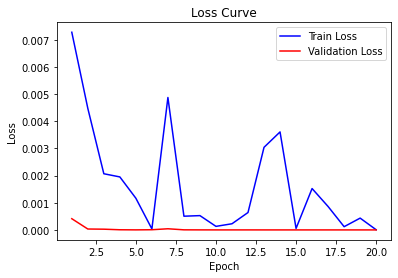

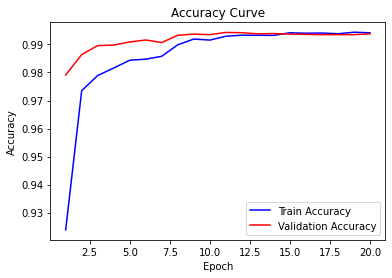

In [5]:
train_loss = [i.item() for i in train_loss]
val_loss = [i.item() for i in val_loss]
train_acc = [i.item() for i in train_acc]
val_acc = [i.item() for i in val_acc]

import matplotlib.pyplot as plt
plt.figure()
plt.plot(range(1,epochs+1), train_loss, color='blue')
plt.plot(range(1,epochs+1), val_loss, color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend(['Train Loss', 'Validation Loss'])
plt.show()

import matplotlib.pyplot as plt
plt.figure()
plt.plot(range(1,epochs+1), train_acc, color='blue')
plt.plot(range(1,epochs+1), val_acc, color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend(['Train Accuracy', 'Validation Accuracy'])
plt.show()

# Load and Predict

In [9]:
name = 'mnist_pytorch_20_0.9943.pth' # Copy and paste the model name after running above tab

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CNN_MNIST()
model.load_state_dict(torch.load(name))
model = model.to(device)

total = 0
correct = 0
with torch.no_grad():
    for (img, label) in test_dl:
        img, label = img.to(device), label.to(device)
        output = model(img)
        _, predicted = torch.max(output.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()
print(f"Accuracy on Test set : {correct/total}")

Accuracy on Test set : 0.9886
